<a href="https://colab.research.google.com/github/sled13/for_colab_nb/blob/main/Distribution_controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# input:
2-column distribution .csv - file with column names 'id' (string) and 'count' (non-negative float).
1. you need upload ore generate the file

In [43]:

file_name = "random_generated.csv" # @param {"type":"string","placeholder":"define analyzed filr name "}


# Generate random input.

In [44]:
seed = 1 # @param {"type":"integer","placeholder":"define seed"}
level_narrow = 50 # @param {"type":"number","placeholder":"define level for bigs"}

#you may change all parameters
#TODO: inert form filds
n_items=100
n_narrow=3
n_small=5
level_middle=15
level_small=3


id_preffix="id_"
import numpy as np
import pandas as pd

def generate_random_input():
  result={}
  np.random.seed(seed=seed)
  n_middle=n_items-n_narrow-n_small

  mu, sigma = level_small, 3*level_small # mean and standard deviation
  smalls = np.random.normal(mu, sigma, n_small)
  for ii in range(len(smalls)):
    id=f"{id_preffix}sml_{ii}"
    result[id]=max(0,smalls[ii])
  mu, sigma = level_middle, 0.8*level_middle # mean and standard deviation
  middles = np.random.normal(mu, sigma, n_middle)
  for ii in range(len(middles)):
    id=f"{id_preffix}mid_{ii}"
    result[id]=max(level_small*0.2,middles[ii])
  mu, sigma = level_narrow, 0.7*level_narrow # mean and standard deviation
  bigs = np.random.normal(mu, sigma, n_narrow)
  for ii in range(len(bigs)):
    id=f"{id_preffix}big_{ii}"
    result[id]=max(level_middle*0.3,bigs[ii])

 # for id in result:
 #   print(id,result[id])
  ids=list (result.keys())
  counts=list(result.values())
  df_res=pd.DataFrame(data={'id':ids,'count':counts})

  df_res.index.name ='record'
  print(df_res)
  df_res.to_csv("random_generated.csv")

generate_random_input()

               id      count
record                      
0        id_sml_0  17.619108
1        id_sml_1   0.000000
2        id_sml_2   0.000000
3        id_sml_3   0.000000
4        id_sml_4  10.788669
...           ...        ...
95      id_mid_90  15.928081
96      id_mid_91  10.873756
97       id_big_0  51.525890
98       id_big_1  28.299970
99       id_big_2  74.431121

[100 rows x 2 columns]


## Analysis of the file

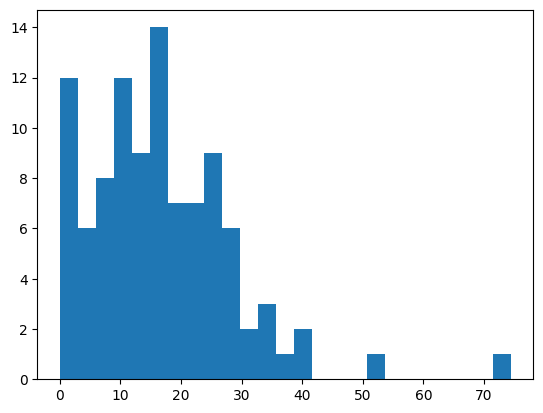

all data 100 filtered out 8 small
          record      count
count  92.000000  92.000000
mean   51.239130  18.111698
std    28.003677  11.528651
min     0.000000   1.289782
3%      6.730000   1.798946
50%    50.500000  17.071161
97%    96.270000  40.479499
max    99.000000  74.431121
middle intervals: l_bound=1.798946364159225 r_bound=40.4794993127221; counters=86
mid_average=17.376950184098938,mid_std=8.628968406013094,
2-sigma bound = 34.634886996125125 3-sigma bound = 43.26385540213822


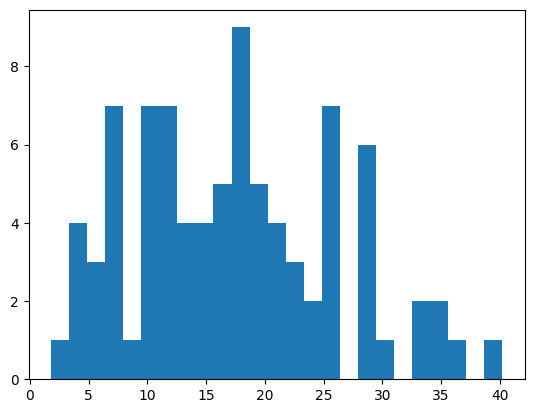

    record         id      count    level2    level3  suspect_level
6        6   id_mid_1  35.937741  0.150986  0.000000       0.075493
38      38  id_mid_33  34.917626  0.032766  0.000000       0.016383
43      43  id_mid_38  35.309455  0.078175  0.000000       0.039087
47      47  id_mid_42  40.203062  0.645289  0.000000       0.322644
68      68  id_mid_63  41.226905  0.763940  0.000000       0.381970
97      97   id_big_0  51.525890  1.957477  0.957477       1.457477
99      99   id_big_2  74.431121  4.611934  3.611934       4.111934
with sevirity = 'med' the file random_generated.csv represents 'narrow' distribution with 2 outlayers


<Figure size 640x480 with 0 Axes>

In [45]:
percentile_level = 0.03 # @param {"type":"number","placeholder":"define percentile level to cutoff"}
weight_level2 = 0.5 # @param {"type":"number","placeholder":"define weight_level"}
sevirity = "med" # @param ["low","med","high"]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#percentile_level=0.03
sevirity_translator={"low":0.1, 'med':0.95,"high":1.9}


df_=pd.read_csv(file_name)
NN=df_.shape[0]
all_counters=df_['count']
plt.hist(all_counters, bins=25)
plt.show()
plt.clf()

df_rest=df_.drop(df_[df_['count']<1].index)
NN_rest=df_rest.shape[0]
if NN_rest>0.1*NN:
  print(f"all data {NN} filtered out {NN-NN_rest} small")

else:
  print(f"all data {NN} filtered out 0 small")
  df_rest=df_

df_descr=df_rest.describe(percentiles=[percentile_level,1-percentile_level])
print(df_descr)

l_bound=df_descr.loc[f'{round(100*percentile_level)}%']['count']
r_bound=df_descr.loc[f'{round(100*(1-percentile_level))}%']['count']
middle_counts=[count for count in all_counters if count>l_bound and count<r_bound ]
print(f'middle intervals: l_bound={l_bound} r_bound={r_bound}; counters={len(middle_counts)}')

avg_=np.mean(middle_counts)
std_=np.std(middle_counts)
sigma2_bound=avg_+2*std_
sigma3_bound=avg_+3*std_
print(f'mid_average={avg_},mid_std={std_},\n2-sigma bound = {sigma2_bound} 3-sigma bound = {sigma3_bound}' )
plt.hist(middle_counts, bins=25)
plt.show()
plt.clf()

df_rest['level2']=(df_rest['count']-sigma2_bound)/std_
df_rest['level3']=(df_rest['count']-sigma3_bound)/std_
df_outliers = df_rest.drop(df_rest[df_rest['level2']<=0].index)
#print(df_outliers)
df_outliers.loc[df_outliers['level3']<0,'level3']=0
#print(df_outliers)
df_outliers['suspect_level']=weight_level2*df_outliers['level2']+\
 (1-weight_level2)*df_outliers['level3']
df_outliers.loc[df_outliers['suspect_level']>10,'suspect_level']=10
print(df_outliers)
df_outlayers=df_outliers.\
drop(df_outliers[df_outliers['suspect_level']<sevirity_translator[sevirity]].index)
out_res=df_outlayers[['id','count','suspect_level']]
out_res.to_csv(f"outliers_{sevirity}={file_name}", index=False)
conclution_file=f"conclusion_{sevirity}={file_name}"
conclution_file=conclution_file.replace('.csv','.txt')
outl_num=out_res.shape[0]
if outl_num<1:
  mesage=f"with sevirity = '{sevirity}' the file {file_name} represents 'wide' distribution"
else:
   mesage=f"with sevirity = '{sevirity}' the file {file_name} represents 'narrow' distribution with {outl_num} outlayers"
print(mesage)
with open(conclution_file,'w') as out:
  out.write(mesage)


In [46]:
#!zip -r distribution_experiments.zip "/content/for_zip"

  adding: content/for_zip/ (stored 0%)
  adding: content/for_zip/.ipynb_checkpoints/ (stored 0%)
  adding: content/for_zip/conclusion_med=random_generated.txt (deflated 14%)
  adding: content/for_zip/outliers_med=random_generated_8.csv (stored 0%)
  adding: content/for_zip/conclusion_high=random_generated_50.txt (deflated 13%)
  adding: content/for_zip/conclusion_med=random_generated_15.txt (deflated 12%)
  adding: content/for_zip/outliers_high=random_generated_15.csv (stored 0%)
  adding: content/for_zip/outliers_low=random_generated_15.csv (deflated 39%)
  adding: content/for_zip/conclusion_high=random_generated_8.txt (deflated 12%)
  adding: content/for_zip/outliers_high=random_generated_100.csv (deflated 15%)
  adding: content/for_zip/outliers_high=random_generated_8.csv (stored 0%)
  adding: content/for_zip/outliers_med=random_generated_50.csv (deflated 18%)
  adding: content/for_zip/random_generated_8.csv (deflated 56%)
  adding: content/for_zip/outliers_low=random_generated_100.